## Búsqueda del mejor modelo entre las configuraciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import numpy as np
import re
import ast

In [4]:
dfs = {
    #'SBP_MEDIUM': pd.read_csv('SBP_MEDIUM_new_archit.csv'),   # Resultados varias profs y reevals
    'SBP_MEDIUM': pd.read_csv('Resultados_busqueda/SBP_MEDIUM_ALL.csv'),
    'SBP_HARD': pd.read_csv('Resultados_busqueda/SBP_HARD_new_arch.csv'),
    #'CBP_HARD': pd.read_csv('CBP_HARD_testing_alg.csv'),   # Resultados varias profs y reevals
    'CBP_HARD': pd.read_csv('Resultados_busqueda/CBP_HARD_ALL.csv')
}

In [7]:
# Ver las columnas de cada df
for df_name, df in dfs.items():
    print(df_name)
    print(df.columns)

SBP_MEDIUM
Index(['FEN', 'Moves', 'Moves_UCI', 'Puzzle_ID',
       'AlgorithmProposed_results_depth_2_preeval_3',
       'AlgorithmProposed_results_depth_3_preeval_3',
       'AlgorithmProposed_results_depth_4_preeval_3',
       'AlgorithmProposed_results_depth_2_preeval_4',
       'AlgorithmProposed_results_depth_3_preeval_4',
       'AlgorithmProposed_results_depth_4_preeval_4',
       ...
       'AlgorithmProposedIterative_results_depth_5_percentage_0.1_preeval_10',
       'AlgorithmProposedIterative_results_depth_5_percentage_0.4_preeval_10',
       'AlgorithmProposedIterative_results_depth_5_percentage_0.2_preeval_10',
       'AlgorithmProposedIterative_results_depth_5_percentage_0.3_preeval_10',
       'AlgorithmProposedIterative_results_depth_5_percentage_0.5_preeval_10',
       'AlgorithmProposedIterative_results_depth_5_percentage_epsilon_0.1_preeval_10',
       'AlgorithmProposedIterative_results_depth_5_percentage_epsilon_0.2_preeval_10',
       'AlgorithmProposedIterative_r

In [13]:
for df_name, df in dfs.items():
    print(tabulate(df, headers='keys', tablefmt='psql'))

wp': np.float64(0.5007759443531077), 'cp': 0}}                 | {'g2g3': {'wp': np.float64(0.5313365333043825), 'cp': 34}, 'g2h3': {'wp': np.float64(0.6164179598164896), 'cp': 128}, 'a2a4': {'wp': np.float64(0.5256290140722664), 'cp': 27}, 'a2a3': {'wp': np.float64(0.5185996089631528), 'cp': 20}, 'd3e2': {'wp': np.float64(0.5007759443531077), 'cp': 0}}                 | {'g2g3': {'wp': np.float64(0.5313365333043825), 'cp': 34}, 'g2h3': {'wp': np.float64(0.6164179598164896), 'cp': 128}, 'a2a4': {'wp': np.float64(0.5256290140722664), 'cp': 27}, 'a2a3': {'wp': np.float64(0.5185996089631528), 'cp': 20}, 'd3e2': {'wp': np.float64(0.5007759443531077), 'cp': 0}}                 | {'g2g3': {'wp': np.float64(0.5313365333043825), 'cp': 34}, 'g2h3': {'wp': np.float64(0.6164179598164896), 'cp': 128}, 'a2a4': {'wp': np.float64(0.5256290140722664), 'cp': 27}, 'a2a3': {'wp': np.float64(0.5185996089631528), 'cp': 20}, 'd3e2': {'wp': np.float64(0.5007759443531077), 'cp': 0}}                 | {'g2g3':

Para cada dataset de resultados se tiene que cada valor de la columna es un diccionario para cada jugada legal:

- Jugada legal

- Puntuación probabilidad

- Puntuación centipeones

Por cada jugada legal, hay dos valores. La jugada que hace el modelo será la de mayor puntuación o probabilidad de victoria

Para cada df primero vamos a almacenar en otra variable la solución

In [10]:
lista_soluciones_por_df = {}

for df_name, df in dfs.items():
    lista_soluciones_por_df[df_name] = df['Moves_UCI'].tolist()

Vamos a crear un dataframe en que cada columna es el id del puzzle, otra el movimiento correcto ('Moves_UCI') y en las otras las valoraciones de los modelos.

In [13]:
def limpiar_y_convertir_a_diccionario(jugada_str):
    try:
        # Elimina np.float64 envolviendo los números
        jugada_str = jugada_str.replace('np.float64(', '').replace(')', '')
        return ast.literal_eval(jugada_str)  # eval seguro
    except Exception as e:
        print("Error al convertir a diccionario:", e)
        return None

def buscar_prob_valorada_por_modelo_segun_real(moves_results, real_moves):
    """
    Esta función obtiene la probabilidad de la jugada real (Moves_UCI)
    según el diccionario de movimientos evaluado por un modelo.
    """
    prob = []
    for idx, move in enumerate(real_moves):
        try:
            moves_dict = limpiar_y_convertir_a_diccionario(moves_results.iloc[idx])
            if moves_dict is not None and move in moves_dict:
                prob.append(float(moves_dict[move]['wp']))
            else:
                prob.append(None)
        except Exception as e:
            print(f"Error procesando move '{move}' en índice {idx}: {e}")
            prob.append(None)
    return prob

def obtener_mejor_jugada(lista_dicts):
    """
    Para cada diccionario de jugadas, devuelve la jugada con mayor 'wp'.
    """
    maxs = []
    for jugada in lista_dicts:
        dict_aux = limpiar_y_convertir_a_diccionario(jugada)
        if dict_aux:
            try:
                mejor = max(dict_aux.items(), key=lambda x: x[1]['wp'])[0]
                maxs.append(mejor)
            except Exception as e:
                print("Error extrayendo mejor jugada:", e)
                maxs.append(None)
        else:
            maxs.append(None)
    return maxs

Ahora vamos a recoger la jugada que haría cada modelo cuyos resultados están recogidos en los df

In [29]:

columnas_algoritmos = [col for col in dfs['SBP_MEDIUM'].columns if col.startswith('AlgorithmProposed')]

columnas_por_modelo = {col: col for col in columnas_algoritmos}


# Inicializar estructura para almacenar jugadas por modelo
jugadas_por_modelo = {modelo: {} for modelo in columnas_por_modelo}

# Función para limpiar y convertir las cadenas
def limpiar_y_convertir_a_diccionario(cadena):
    try:
        cadena_limpia = re.sub(r'np\.float64\(([0-9eE\.\-+]+)\)', r'\1', cadena)

        return ast.literal_eval(cadena_limpia)
    except Exception as e:
        print("Error al limpiar y convertir:", e)
        return None

# Iterar sobre los DataFrames y calcular jugadas por modelo
for df_name, df in dfs.items():
    for modelo, columna in columnas_por_modelo.items():
        if columna in df.columns:
            jugadas_por_modelo[modelo][df_name] = obtener_mejor_jugada(df[columna])
        else:
            jugadas_por_modelo[modelo][df_name] = None



Dado que ya tenemos la jugada que haría cada modelo, PODEMOS CALCULAR EL ACCURACY DE CADA MODELO

In [25]:
acc_por_modelo = {modelo: {} for modelo in jugadas_por_modelo.keys()}

# Calcular precisión por modelo y por DataFrame
for modelo in jugadas_por_modelo:
    for df_name, jugadas_predichas in jugadas_por_modelo[modelo].items():
        if jugadas_predichas is None or df_name not in dfs:
            acc_por_modelo[modelo][f"{df_name}_{modelo}"] = None
            continue

        true_moves = dfs[df_name]['Moves_UCI']
        
        # Aseguramos que las longitudes coincidan
        if len(true_moves) != len(jugadas_predichas):
            print(f"Longitud distinta en {df_name} ({modelo})")
            acc_por_modelo[modelo][f"{df_name}_{modelo}"] = None
            continue

        acc = (true_moves == jugadas_predichas).mean()
        acc_por_modelo[modelo][f"{df_name}_{modelo}"] = acc

In [28]:
from tabulate import tabulate

# Construimos la tabla: df_name -> modelo -> accuracy
acc_tabla = {}

for modelo, accs in acc_por_modelo.items():
    for df_tag, valor in accs.items():
        # Extraer el nombre real del dataset (sin sufijo)
        df_name = df_tag.replace(f'_{modelo}', '')
        if df_name not in acc_tabla:
            acc_tabla[df_name] = {}
        acc_tabla[df_name][modelo] = valor

# Obtener lista completa de modelos para mantener orden
todos_los_modelos = sorted(acc_por_modelo.keys())

# Encabezados para la tabla
headers = ['df_name'] + todos_los_modelos
rows = []

# Construimos cada fila para la tabla
for df_name in sorted(acc_tabla.keys()):
    row = [df_name]
    for modelo in todos_los_modelos:
        val = acc_tabla[df_name].get(modelo)
        row.append(round(val, 3) if isinstance(val, float) else val)
    rows.append(row)

# Mostrar tabla con tabulate
print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))


╒════════════╤═══════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════

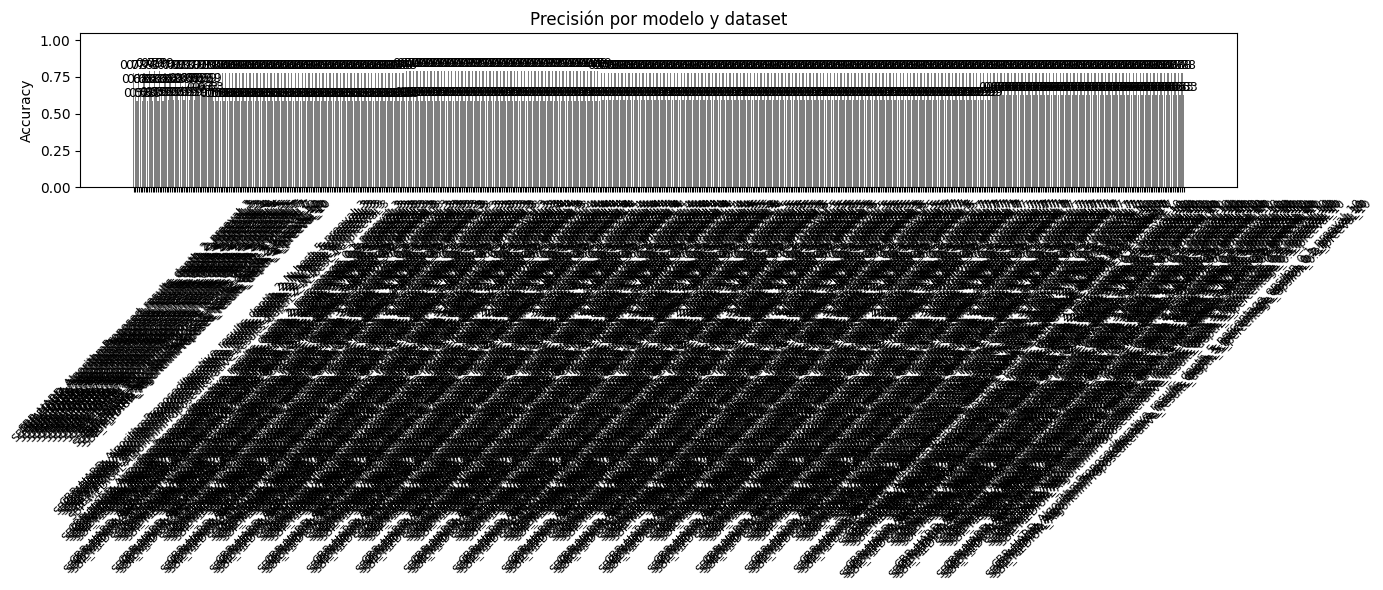

In [31]:
acc_all = {}

# Construimos el diccionario acc_all
for modelo, accs in acc_por_modelo.items():
    for df_tag, valor in accs.items():
        acc_all[df_tag] = valor

# Filtramos los valores None
acc_all = {k: v for k, v in acc_all.items() if v is not None}

labels = list(acc_all.keys())
values = list(acc_all.values())

# Función para asignar color según si contiene ciertas cadenas
def asignar_color(label):
    if "9M" in label:
        return "orange"
    elif "136M" in label:
        return "green"
    elif "270M" in label:
        return "red"
    elif "St_all_moves" in label:
        return "purple"
    elif "St_20depth" in label:
        return "blue"
    else:
        return "gray"

colors = [asignar_color(label) for label in labels]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(labels, values, color=colors)

# Etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.01,
             f'{height:.2f}',
             ha='center',
             va='bottom',
             fontsize=9)

plt.ylabel('Accuracy')
plt.xticks(rotation=45, fontsize=8)
plt.title('Precisión por modelo y dataset')
plt.ylim(0, 1.05)
plt.tight_layout()

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='orange', label='9M*'),
    Patch(facecolor='green', label='136M*'),
    Patch(facecolor='red', label='270M*'),
    Patch(facecolor='purple', label='St_all_moves'),
    Patch(facecolor='blue', label='St_20depth'),
   # Patch(facecolor='gray', label='Otros'),
]
#plt.legend(handles=legend_elements, title="Categorías", loc='upper right')

plt.show()

A continuación vamos a calcular los estadísticos usuales por dataset. Esto es, por ejemplo, para todos los resultados de SBP_MEDIUM obtener los estadísticos como la media, máximo, mínimo,... Con el objetivo de poder exponer un resumen

In [34]:
# A  continuación vamos a calcular los estadísticos usuales por dataset. Esto es, por ejemplo, para todos los resultados de SBP_MEDIUM obtener los estadísticos como la media, máximo, mínimo,... Con el objetivo de poder exponer un resumen
# Usando acc_por_modelo hacemos el calculo por dataset

summary = {}

for df_name, df in acc_por_modelo.items():
    print(df_name)
    print(df)

AlgorithmProposed_results_depth_2_preeval_3
{'SBP_MEDIUM_AlgorithmProposed_results_depth_2_preeval_3': 0.7763157894736842, 'SBP_HARD_AlgorithmProposed_results_depth_2_preeval_3': 0.6761658031088082, 'CBP_HARD_AlgorithmProposed_results_depth_2_preeval_3': 0.583732057416268}
AlgorithmProposed_results_depth_3_preeval_3
{'SBP_MEDIUM_AlgorithmProposed_results_depth_3_preeval_3': 0.7763157894736842, 'SBP_HARD_AlgorithmProposed_results_depth_3_preeval_3': 0.6761658031088082, 'CBP_HARD_AlgorithmProposed_results_depth_3_preeval_3': 0.583732057416268}
AlgorithmProposed_results_depth_4_preeval_3
{'SBP_MEDIUM_AlgorithmProposed_results_depth_4_preeval_3': 0.7763157894736842, 'SBP_HARD_AlgorithmProposed_results_depth_4_preeval_3': 0.6761658031088082, 'CBP_HARD_AlgorithmProposed_results_depth_4_preeval_3': 0.583732057416268}
AlgorithmProposed_results_depth_2_preeval_4
{'SBP_MEDIUM_AlgorithmProposed_results_depth_2_preeval_4': 0.7894736842105263, 'SBP_HARD_AlgorithmProposed_results_depth_2_preeval_4':

## Selección de la mejor configuración

Los resultados medios a grandes rasgos por algoritmo propuesto pueden verse en la memoria del trabajo. En particular, se observa que los mejores resultados medios en relación accuracy-tiempo son para el algoritmo de búsqueda iterativa usando N_best. Se continua acotando aún más al mejor modelo hasta seleccionar uno de ellos, sobre el cual se trabajará a continuación.

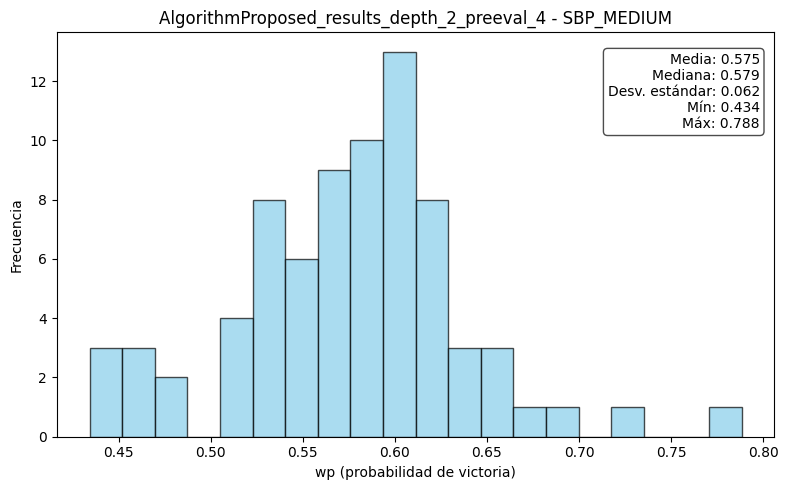

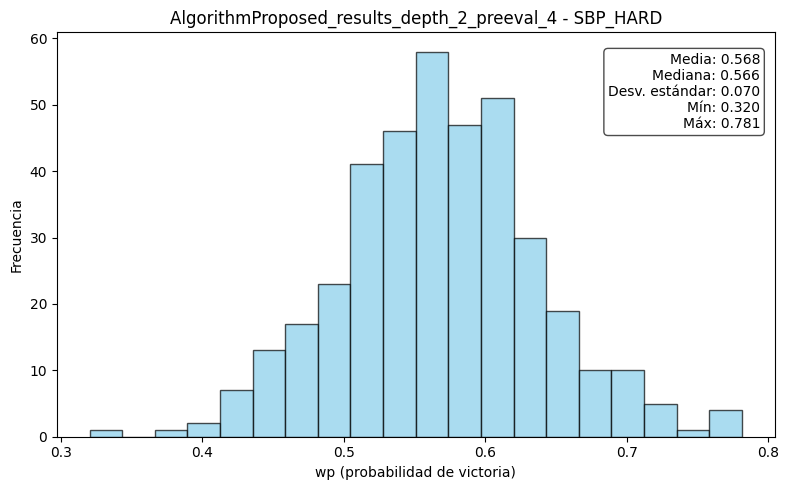

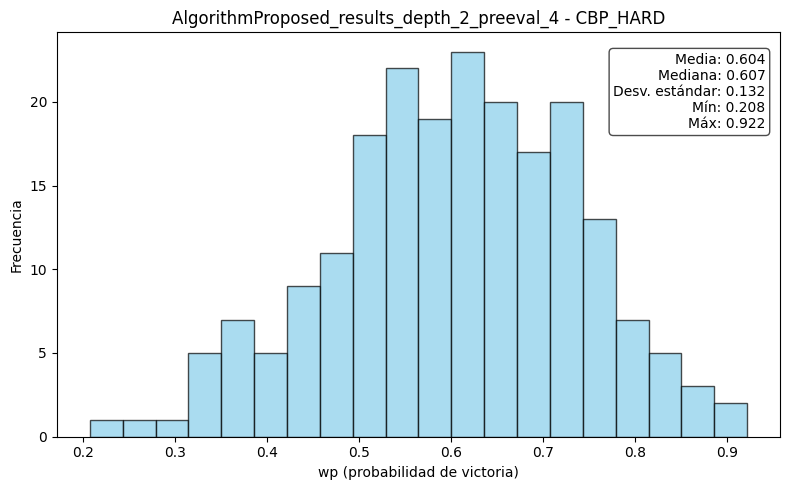

In [37]:
# Vamos a obtener solo los histogramas de AlgorithmProposed e IterativeAlgorithmProposed para N_best por ser 
# el primero un comparador del segundo, que es el que mejores resultados da

columnas_referencia = [
    'AlgorithmProposed_results_depth_2_preeval_4'
]


def obtener_probabilidades(lista_dicts):
    maxs = []
    for jugada in lista_dicts:
        dict_aux = limpiar_y_convertir_a_diccionario(jugada)
        if dict_aux is not None:
            try:
                max_wp = max(dict_aux.items(), key=lambda x: x[1]['wp'])[1]['wp']
                maxs.append(max_wp)
            except Exception as e:
                print(f"Error extrayendo wp: {e}")
                maxs.append(None)
        else:
            maxs.append(None)
    return [x for x in maxs if x is not None]

# Obtener columnas de referencia desde SBP_MEDIUM
#columnas_referencia = []

#for col in df.columns:
    
#    if 'N_best' in col or 'AlgorithmProposed_' in col:
#        print(col)
#        columnas_referencia.append(col)


# Graficar los histogramas para cada modelo según columnas de SBP_MEDIUM
for df_name, df in dfs.items():
    for col in columnas_referencia:
        if col not in df.columns:
            print(f"[{df_name} - {col}] Columna no disponible. Saltando.")
            continue

        columna = df[col]
        probabilidades = obtener_probabilidades(columna)

        if len(probabilidades) == 0:
            print(f"[{df_name} - {col}] No se encontraron probabilidades válidas.")
            continue

        # Calcular estadísticos
        media = np.mean(probabilidades)
        mediana = np.median(probabilidades)
        std = np.std(probabilidades)
        minimo = np.min(probabilidades)
        maximo = np.max(probabilidades)

        plt.figure(figsize=(8, 5))
        plt.hist(probabilidades, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{col} - {df_name}")
        plt.xlabel("wp (probabilidad de victoria)")
        plt.ylabel("Frecuencia")

        stats_text = (f"Media: {media:.3f}\n"
                      f"Mediana: {mediana:.3f}\n"
                      f"Desv. estándar: {std:.3f}\n"
                      f"Mín: {minimo:.3f}\n"
                      f"Máx: {maximo:.3f}")

        plt.text(0.98, 0.95, stats_text,
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

        plt.tight_layout()
        plt.show()


In [38]:
columnas_algoritmos = [
    'AlgorithmProposed_results_depth_2_preeval_4',
    'stockfish_all_moves_results_20depth',
    'stockfish_all_moves_results'
]

columnas_por_modelo = {col: col for col in columnas_algoritmos}


# Inicializar estructura para almacenar jugadas por modelo
jugadas_por_modelo = {modelo: {} for modelo in columnas_por_modelo}

# Función para limpiar y convertir las cadenas
def limpiar_y_convertir_a_diccionario(cadena):
    try:
        cadena_limpia = re.sub(r'np\.float64\(([0-9eE\.\-+]+)\)', r'\1', cadena)

        return ast.literal_eval(cadena_limpia)
    except Exception as e:
        print("Error al limpiar y convertir:", e)
        return None

# Iterar sobre los DataFrames y calcular jugadas por modelo
for df_name, df in dfs.items():
    for modelo, columna in columnas_por_modelo.items():
        if columna in df.columns:
            jugadas_por_modelo[modelo][df_name] = obtener_mejor_jugada(df[columna])
        else:
            jugadas_por_modelo[modelo][df_name] = None

In [47]:
# Ahora vamos a coger los puzzles en los que falle benchess. que son los que Moves_UCI es distinto a la mejor jugada
# de las calculadas antes. Lo que haremos será quedarnos con esas filas y el dato correspondiente al movimiento
# El objetivo es después tratar las probabilidades, wp, asociadas a cada movimiento hecho
puzzles_fallados_por_modelo = {
    'AlgorithmProposed_results_depth_2_preeval_4': {},
    'stockfish_all_moves_results_20depth': {},
    'stockfish_all_moves_results': {}
}

for df_name, df in dfs.items():
    for modelo in list(puzzles_fallados_por_modelo.keys()):  # Convertimos las keys a lista para evitar modificación durante iteración
        if modelo not in jugadas_por_modelo:  # Verificamos que el modelo existe en jugadas_por_modelo
            print(f"Advertencia: El modelo {modelo} no está en jugadas_por_modelo")
            continue
            
        jugadas_predichas = jugadas_por_modelo[modelo].get(df_name)

        if jugadas_predichas is None:
            puzzles_fallados_por_modelo[modelo][df_name] = None
            continue

        # Comparamos la jugada real vs la predicha
        fallos = df[df['Moves_UCI'] != jugadas_predichas]
        puzzles_fallados_por_modelo[modelo][df_name] = fallos


A continuación, por cada puzzle de cada dataset que falla cada modelo, extraemos las probabilidades de victoria, wp, asociada a cada modelo respectivamente, junto a las de Stockfish con tiempo 0.05s y Stockfish con profundidad 20

In [74]:
# Función para extraer la probabilidad de victoria de la mejor jugada en cada diccionario
def obtener_probabilidades_victoria(lista_dicts):
    maxs = []
    for jugada in lista_dicts:
        dict_aux = limpiar_y_convertir_a_diccionario(jugada)
        if dict_aux is not None:
            try:
                max_wp = max(dict_aux.items(), key=lambda x: x[1]['wp'])[1]['wp']
                maxs.append(max_wp)
            except Exception as e:
                print("Error extrayendo wp:", e)
                maxs.append(None)
        else:
            maxs.append(None)

    return [x for x in maxs if x is not None]

# Diccionario centralizado con las probabilidades de victoria por modelo y por df, solo en puzzles fallados
probs_victoria_por_modelo = {
    'AP_depth_2_preeval_4': {},
    'St0.05': {},
    'St_pr20': {}
}

# Asociamos columnas a los modelos
columnas_por_modelo = {
    'AP_depth_2_preeval_4': 'AlgorithmProposed_results_depth_2_preeval_4',
    'St0.05': 'stockfish_all_moves_results',
    'St_pr20': 'stockfish_all_moves_results_20depth'
}

modelo_mapping = {
    'AlgorithmProposed_results_depth_2_preeval_4': 'AP_depth_2_preeval_4',
    'stockfish_all_moves_results': 'St0.05',
    'stockfish_all_moves_results_20depth': 'St_pr20'
}

for modelo_original, puzzles_por_df in puzzles_fallados_por_modelo.items():
    # Obtenemos el nombre mapeado del modelo
    modelo = modelo_mapping.get(modelo_original)
    
    if modelo is None:  # Si no existe mapeo, continuamos con el siguiente
        continue
        
    for df_name, df_fallos in puzzles_por_df.items():
        if df_fallos is None or columnas_por_modelo.get(modelo) not in df_fallos.columns:
            probs_victoria_por_modelo[modelo][df_name] = None
            continue

        columna = columnas_por_modelo[modelo]
        lista_dicts = df_fallos[columna]
        probs_victoria_por_modelo[modelo][df_name] = obtener_probabilidades_victoria(lista_dicts)



Para comenzar con el análisis comparativo entre los modelos y Stockfish en sus variantes podemos hacer una comparación de medias de probabilidades.

In [77]:
tabla_resultados = {}

for modelo, resultados_por_df in probs_victoria_por_modelo.items():
    for df_name, lista_probs in resultados_por_df.items():
        if df_name not in tabla_resultados:
            tabla_resultados[df_name] = {}
        
        if lista_probs is None or len(lista_probs) == 0:
            promedio = None
        else:
            promedio = np.mean(lista_probs)
        
        tabla_resultados[df_name][modelo] = promedio

# Preparar headers y filas para tabulate
modelos = list(probs_victoria_por_modelo.keys())
headers = ['df_name'] + modelos
filas = []

for df_name in sorted(tabla_resultados.keys()):
    fila = [df_name]
    for modelo in modelos:
        valor = tabla_resultados[df_name].get(modelo, None)
        fila.append(round(valor, 3) if isinstance(valor, float) else valor)
    filas.append(fila)

# Mostrar tabla
print(tabulate(filas, headers=headers, tablefmt="fancy_grid"))


╒════════════╤════════════════════════╤══════════╤═══════════╕
│ df_name    │   AP_depth_2_preeval_4 │   St0.05 │   St_pr20 │
╞════════════╪════════════════════════╪══════════╪═══════════╡
│ CBP_HARD   │                  0.567 │    0.623 │     0.678 │
├────────────┼────────────────────────┼──────────┼───────────┤
│ SBP_HARD   │                  0.564 │    0.582 │     0.583 │
├────────────┼────────────────────────┼──────────┼───────────┤
│ SBP_MEDIUM │                  0.568 │    0.582 │     0.567 │
╘════════════╧════════════════════════╧══════════╧═══════════╛


A continuación vamos a añadir a cada diccionario una columna con la diferencia de wp Stockfish-benchess

In [83]:
diferencias_wp_con_stockfish = {
    'AlgorithmProposed_results_depth_2_preeval_4': {},
}

columnas_por_modelo = {
    'AlgorithmProposed_results_depth_2_preeval_4': 'AlgorithmProposed_results_depth_2_preeval_4',
    'St0.05': 'stockfish_all_moves_results',
    'St_pr20': 'stockfish_all_moves_results_20depth'
}


def extraer_wp(lista_dicts):
    """Extrae la wp de la mejor jugada."""
    wps = []
    for jugada in lista_dicts:
        dict_aux = limpiar_y_convertir_a_diccionario(jugada)
        if dict_aux is not None:
            try:
                wp = max(dict_aux.items(), key=lambda x: x[1]['wp'])[1]['wp']
                wps.append(wp)
            except:
                wps.append(None)
        else:
            wps.append(None)
    return wps

# Recorremos cada modelo Benchess
for modelo in diferencias_wp_con_stockfish.keys():
    for df_name, df in dfs.items():
        fallos_df = puzzles_fallados_por_modelo[modelo].get(df_name)
        if fallos_df is None:
            diferencias_wp_con_stockfish[modelo][df_name] = None
            continue

        idx_fallos = fallos_df.index
        col_modelo = columnas_por_modelo[modelo]
        col_sf_005 = columnas_por_modelo['St0.05']
        col_sf_20 = columnas_por_modelo['St_pr20']

        # Extraemos las wp solo para los fallos (por índice)
        lista_modelo = extraer_wp(fallos_df[col_modelo])
        lista_sf_005 = extraer_wp(fallos_df[col_sf_005]) if col_sf_005 in fallos_df else [None] * len(fallos_df)
        lista_sf_20 = extraer_wp(fallos_df[col_sf_20]) if col_sf_20 in fallos_df else [None] * len(fallos_df)

        # Calculamos las diferencias
        difs = {
            'St0.05': [sf - m if sf is not None and m is not None else None for sf, m in zip(lista_sf_005, lista_modelo)],
            'St_pr20': [sf - m if sf is not None and m is not None else None for sf, m in zip(lista_sf_20, lista_modelo)]
        }

        diferencias_wp_con_stockfish[modelo][df_name] = difs



Histograma de diferencias

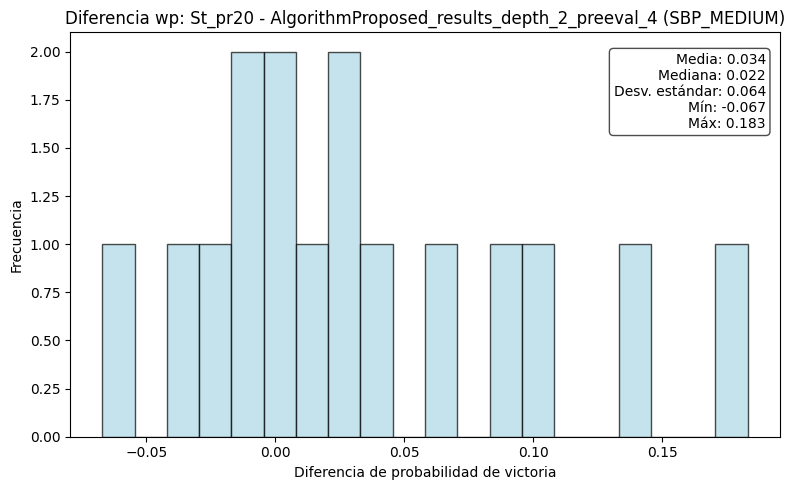

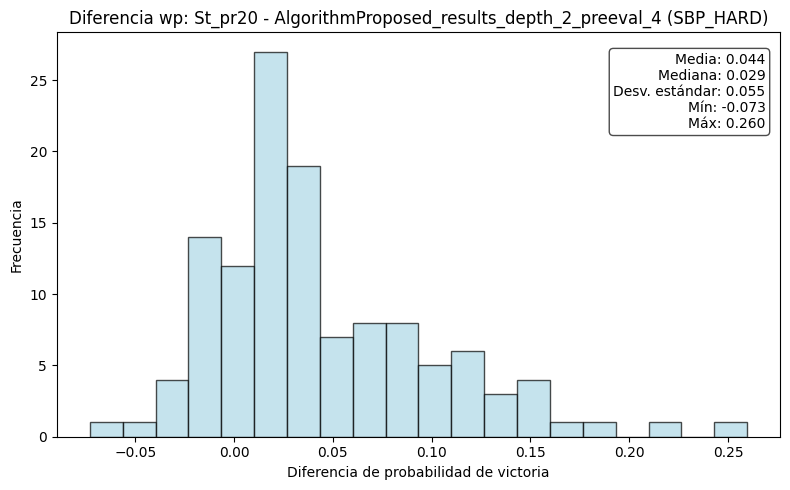

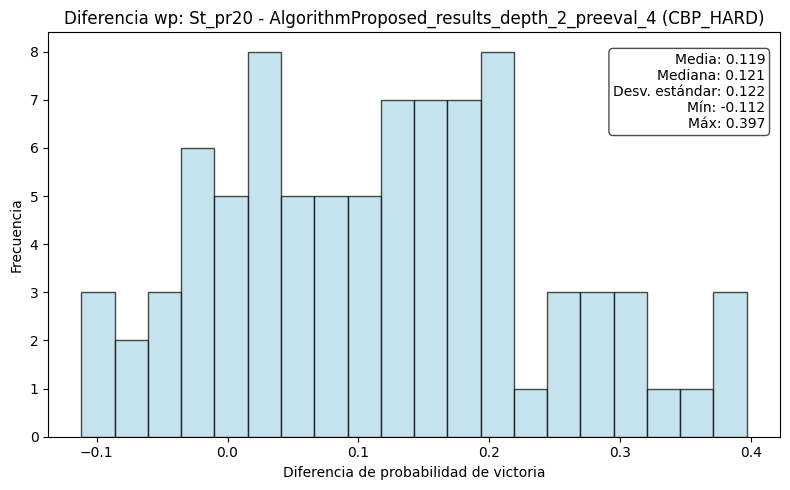

In [86]:
for modelo, datasets in diferencias_wp_con_stockfish.items():
    for df_name, diferencias in datasets.items():
        if not diferencias:
            print(f"[SKIP] {modelo} - {df_name}: diferencias vacías o None")
            continue

        for stockfish_key in [ 'St_pr20']:   #,'St0.05'
            difs = diferencias.get(stockfish_key)

            # Asegurar que existan datos válidos
            if not difs or all(d is None for d in difs):
                print(f"[SKIP] {modelo} - {df_name} - {stockfish_key}: sin datos válidos")
                continue

            # Limpiar Nones por si acaso
            difs_limpias = [d for d in difs if d is not None]

            # Calcular estadísticos
            media = np.mean(difs_limpias)
            mediana = np.median(difs_limpias)
            std = np.std(difs_limpias)
            minimo = np.min(difs_limpias)
            maximo = np.max(difs_limpias)

            plt.figure(figsize=(8, 5))
            plt.hist(difs_limpias, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
            plt.title(f"Diferencia wp: {stockfish_key} - {modelo} ({df_name})")
            plt.xlabel("Diferencia de probabilidad de victoria")
            plt.ylabel("Frecuencia")

            # Agregar estadísticas al gráfico
            stats_text = (f"Media: {media:.3f}\n"
                          f"Mediana: {mediana:.3f}\n"
                          f"Desv. estándar: {std:.3f}\n"
                          f"Mín: {minimo:.3f}\n"
                          f"Máx: {maximo:.3f}")
            
            plt.text(0.98, 0.95, stats_text,
                     transform=plt.gca().transAxes,
                     verticalalignment='top',
                     horizontalalignment='right',
                     bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

            plt.tight_layout()
            plt.show()

In [89]:
tabla_diferencias = []

for modelo, datasets in diferencias_wp_con_stockfish.items():
    for df_name, difs_dict in datasets.items():
        row = [df_name, modelo]

        if difs_dict is None:
            # Si no hay datos, añadimos None para todas las columnas
            row += [None, None, None, None]
        else:
            for clave in ['St0.05', 'St_pr20']:
                difs = difs_dict.get(clave)

                # Validar y limpiar la lista
                if not difs or not isinstance(difs, list):
                    row += [None, None]
                else:
                    difs_limpios = [d for d in difs if d is not None]
                    if not difs_limpios:
                        row += [None, None]
                    else:
                        row += [round(np.mean(difs_limpios), 4), round(np.max(difs_limpios), 4)]

        tabla_diferencias.append(row)

# Encabezados para tabulate
headers = [
    "df_name", "modelo",
    "diff_wp_St0.05_media", "diff_wp_St0.05_max",
    "diff_wp_St_pr20_media", "diff_wp_St_pr20_max"
]

# Mostrar tabla
print(tabulate(tabla_diferencias, headers=headers, tablefmt="fancy_grid"))

╒════════════╤═════════════════════════════════════════════╤════════════════════════╤══════════════════════╤═════════════════════════╤═══════════════════════╕
│ df_name    │ modelo                                      │   diff_wp_St0.05_media │   diff_wp_St0.05_max │   diff_wp_St_pr20_media │   diff_wp_St_pr20_max │
╞════════════╪═════════════════════════════════════════════╪════════════════════════╪══════════════════════╪═════════════════════════╪═══════════════════════╡
│ SBP_MEDIUM │ AlgorithmProposed_results_depth_2_preeval_4 │                 0.0281 │               0.1094 │                  0.0335 │                0.1832 │
├────────────┼─────────────────────────────────────────────┼────────────────────────┼──────────────────────┼─────────────────────────┼───────────────────────┤
│ SBP_HARD   │ AlgorithmProposed_results_depth_2_preeval_4 │                 0.0341 │               0.2291 │                  0.0439 │                0.2597 │
├────────────┼────────────────────────────────

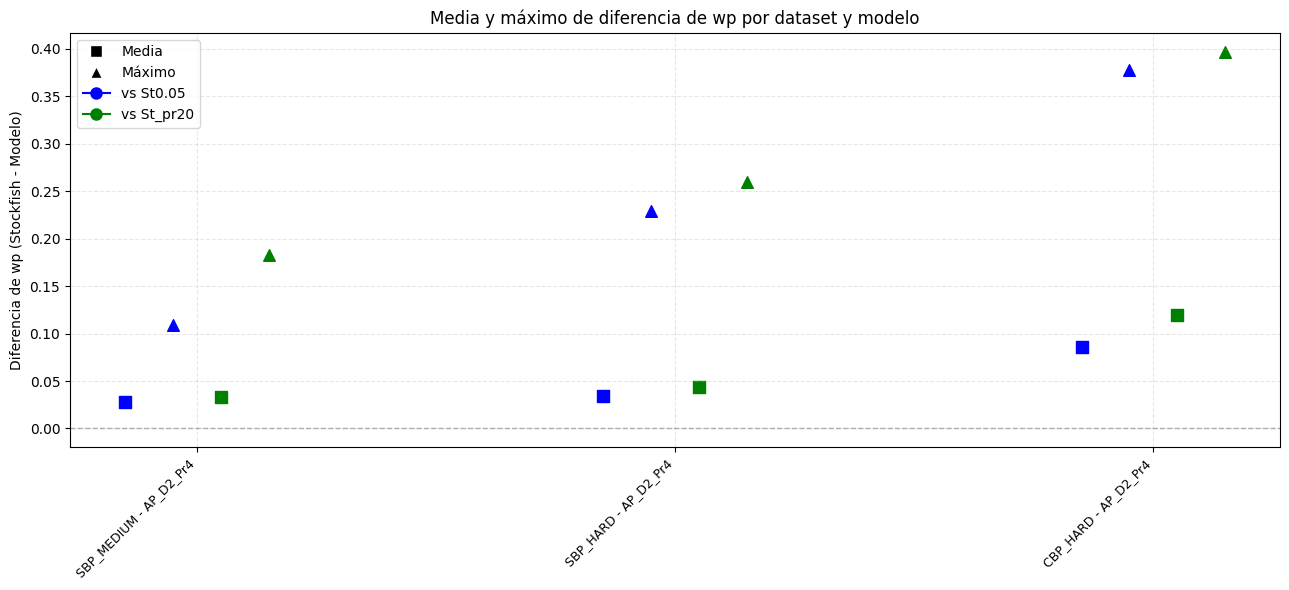

In [98]:
x_positions = []
y_values = []
colors = []
markers = []
x_map = {}
x_labels = []
x_index = 0

for row in tabla_diferencias:
    df_name, modelo, media_005, max_005, media_20, max_20 = row

    if modelo == 'AlgorithmProposed_results_depth_2_preeval_4':
        modelo = 'AP_D2_Pr4'
    label = f"{df_name} - {modelo}"

    if label not in x_map:
        x_map[label] = x_index
        x_labels.append(label)
        x_index += 1

    pos = x_map[label]

    # St0.05
    if media_005 is not None:
        x_positions.append(pos - 0.15)
        y_values.append(media_005)
        colors.append('blue')
        markers.append('s')  # cuadrado = media

    if max_005 is not None:
        x_positions.append(pos - 0.05)
        y_values.append(max_005)
        colors.append('blue')
        markers.append('^')  # triángulo = máximo

    # St_pr20
    if media_20 is not None:
        x_positions.append(pos + 0.05)
        y_values.append(media_20)
        colors.append('green')
        markers.append('s')

    if max_20 is not None:
        x_positions.append(pos + 0.15)
        y_values.append(max_20)
        colors.append('green')
        markers.append('^')

# Crear figura
plt.figure(figsize=(13, 6))

# Dibujar los puntos con colores y marcadores
for x, y, c, m in zip(x_positions, y_values, colors, markers):
    plt.scatter(x, y, color=c, marker=m, s=70)

# Etiquetas del eje X
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right', fontsize=9)

# Detalles visuales
plt.ylabel("Diferencia de wp (Stockfish - Modelo)")
plt.title("Media y máximo de diferencia de wp por dataset y modelo")
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)

# Leyenda personalizada
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', label='Media', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Máximo', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='o', color='blue', label='vs St0.05', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='green', label='vs St_pr20', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

La forma de interpretar la gráfica es tomar la tupla (forma,color) e interpretar. Por ejemplo, (cuadrado,azul) es la media de diferencias de probabilidades con Stockfish a tiempo 0.05s.